# Parallel Reader Tutorial


### Setup a parallel jupyter notebook using ipyparallel
See http://ipyparallel.readthedocs.io for more details on how to set this up

In [1]:
import ipyparallel

# attach to a running cluster
cluster = ipyparallel.Client(profile='mpi')
print('profile:', cluster.profile)
print("IDs:", cluster.ids) # Print process id numbers

('profile:', u'mpi')
('IDs:', [0, 1, 2, 3])


/usr/local/lib/python2.7/dist-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@uzi')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


## Create a serial reader
* Every serial reader extends the `BaseReader` class.
* Should be able to read an arbitrary sub domain of the full grid
* Ability to set and get the viz dump, domain size, etc.

In [2]:
%%px

from mpi4py import MPI
import numpy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

print "rank = %d" %rank

# Import the WCHR Ascii reader module
import floatpy.readers.wchr_ascii_reader as war

# Set filename prefix for the dataset (this is specific to this serial reader)
filename_prefix = '/home/akshays/Data/WCHR-regent/2017_AIAA_AVIATION/WCHR/CHIT2_'

# Initialize the serial reader based on your data format
serial_reader = war.WchrAsciiReader(filename_prefix)

print "Domain size: ", serial_reader.domain_size

[stdout:0] 
rank = 0
Domain size:  (64, 64, 64)
[stdout:1] 
rank = 1
Domain size:  (64, 64, 64)
[stdout:2] 
rank = 2
Domain size:  (64, 64, 64)
[stdout:3] 
rank = 3
Domain size:  (64, 64, 64)


## Create the parallel data reader
* The `ParallelDataReader` class takes any concrete implementation of the abstract `BaseReader`
* Parallelization is built in automatically
* 3D decomposed data
* Supports ghost cell communication and transpose operations

In [3]:
%%px

import floatpy.readers.parallel_reader as pdr

reader = pdr.ParallelDataReader( MPI.COMM_WORLD, serial_reader, num_ghosts=(0, 0, 0) )

print "rank %d: Sub domain: " %(comm.Get_rank()), reader.serial_reader.sub_domain

[stdout:0] rank 0: Sub domain:  ((0, 0, 0), (31, 31, 63))
[stdout:1] rank 1: Sub domain:  ((32, 0, 0), (63, 31, 63))
[stdout:2] rank 2: Sub domain:  ((0, 32, 0), (31, 63, 63))
[stdout:3] rank 3: Sub domain:  ((32, 32, 0), (63, 63, 63))


## Read in coordinates and data

In [4]:
%%px

# Read the coordinates
x, y, z = reader.readCoordinates()

In [5]:
%%px

# Set the visualization step
reader.step = 200

# Read in velocity data for this viz dump
u, v, w = reader.readData( ('u', 'v', 'w') )

## Plotting at runtime
* The `ParallelPlane` class gathers the full plane data given a normal and index

[output:0]

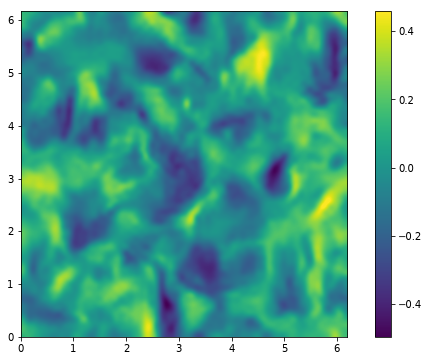

In [10]:
%%px

import floatpy.utilities.parallel_plane as pp

# Create an object to extract an x-y plane with z index 32
plane = pp.ParallelPlane( reader.grid_partition, direction=2, index=0 )

# Get x and y coordinates on the plane
has_plane, x_p = plane.get_plane(x)
has_plane, y_p = plane.get_plane(y)

# Get u velocity on the plane
has_plane, u_p = plane.get_plane(u)

if has_plane:
    plt.figure(figsize=(10,6))
    plt.imshow( u_p, extent=[x_p[0,0], x_p[-1,-1], y_p[0,0], y_p[-1,-1]], origin='lower', interpolation='lanczos', aspect=1. )
    plt.colorbar()
    plt.show()

## Parallel compact derivatives

In [14]:
%%px

from floatpy.derivatives.compact import CompactDerivative


dx = x[1,0,0] - x[0,0,0]
dy = y[0,1,0] - y[0,0,0]
dz = z[0,0,1] - z[0,0,0]

der = CompactDerivative(reader.grid_partition, (dx, dy, dz), (6, 6, 6), reader.periodic_dimensions)

[output:0]

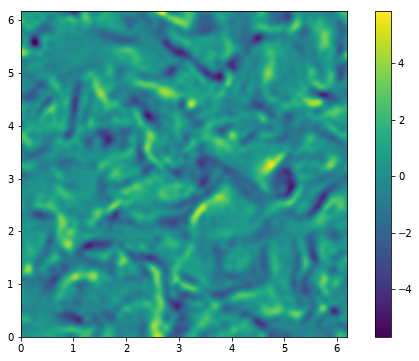

In [16]:
%%px

vorticity = der.curl(u, v, w)

has_plane, vz_p = plane.get_plane(vorticity[:,:,:,2])

if has_plane:
    plt.figure(figsize=(10,6))
    plt.imshow( vz_p, extent=[x_p[0,0], x_p[-1,-1], y_p[0,0], y_p[-1,-1]], origin='lower', interpolation='lanczos', aspect=1. )
    plt.colorbar()
    plt.show()